In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append("/home/pervinco/BKAI_MetaPolyp")

import cv2
import yaml
import random
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from glob import glob
from data.batch_preprocess import *
from utils.utils import decode_mask, decode_image, visualize

In [2]:
with open("/home/pervinco/BKAI_MetaPolyp/config.yaml", "r") as f:
    config = yaml.safe_load(f)

data_dir = config["data_dir"]
image_dir = f"{data_dir}/train"
mask_dir = f"{data_dir}/train_mask"
gt_dir = f"{data_dir}/train_gt"

In [3]:
image_files = sorted(glob(f"{image_dir}/*"))
mask_files = sorted(glob(f"{mask_dir}/*"))
gt_files = sorted(glob(f"{gt_dir}/*"))

In [4]:
def train_img_mask_transform(transform, image, mask): 
    x, y = copy.deepcopy(image), copy.deepcopy(mask)
    transformed = transform(image=x, mask=y)
    transformed_image, transformed_mask = transformed["image"], transformed["mask"]

    return transformed_image, transformed_mask

In [ ]:
        # self.train_transform = A.Compose([A.CLAHE(p=0.4),
        #                                   A.RandomBrightnessContrast(p=0.4),
        #                                   A.Rotate(limit=90, border_mode=0, p=0.6),
        #                                   A.HorizontalFlip(p=0.5),
        #                                   A.VerticalFlip(p=0.5),
        #                                   A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
        #                                   A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
        #                                   A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
        #                                   A.CoarseDropout(p=0.2, max_height=35, max_width=35, fill_value=255, mask_fill_value=0),
        #                                   A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15)])


        # self.piece_transform = A.Compose([A.CLAHE(p=0.4),
        #                                   A.RandomBrightnessContrast(p=0.4),
        #                                   A.HorizontalFlip(p=0.5),
        #                                   A.VerticalFlip(p=0.5)])

In [23]:
train_transform = A.Compose([A.OneOf([A.CLAHE(p=0.3),
                                      A.Sharpen(p=0.3),
                                      A.RandomBrightnessContrast(p=0.3),
                             ], p=1), 
                             
                             A.OneOf([A.Rotate(limit=45, border_mode=0, p=0.25),
                                      A.HorizontalFlip(p=0.25),
                                      A.VerticalFlip(p=0.25),
                                      A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.15, rotate_limit=45, border_mode=0, p=0.25),
                             ], p=1),


                             A.OneOf([A.ColorJitter(p=0.25),
                                      A.RandomGamma(gamma_limit=(70, 130), eps=None, always_apply=False, p=0.25),
                                      A.ChannelDropout(p=0.25),
                                      A.ChannelShuffle(p=0.25)
                             ], p=0.2), 


                             A.OneOf([A.OpticalDistortion(border_mode=0, p=0.5),
                                      A.GridDistortion(border_mode=0, p=0.5)
                             ], p=0.3),

                            
                             A.OneOf([A.Blur(p=0.125), 
                                      A.GaussianBlur(p=0.125), 
                                      A.GlassBlur(p=0.125), 
                                      A.MotionBlur(p=0.125), 
                                      A.GaussNoise(p=0.125), 
                                      A.Sharpen(p=0.125), 
                                      A.MedianBlur(p=0.125), 
                                      A.MultiplicativeNoise(p=0.125)
                             ], p=0.4),
                             
                             A.OneOf([A.CoarseDropout(max_height=35, max_width=35, fill_value=0, mask_fill_value=0, p=0.5),
                                      A.Compose([A.CropNonEmptyMaskIfExists(height=config["img_size"]-56, width=config["img_size"]-56, p=1),
                                                 A.PadIfNeeded(min_height=config["img_size"], min_width=config["img_size"], border_mode=0, p=1)], p=0.5)
                             ], p=0.4)
])

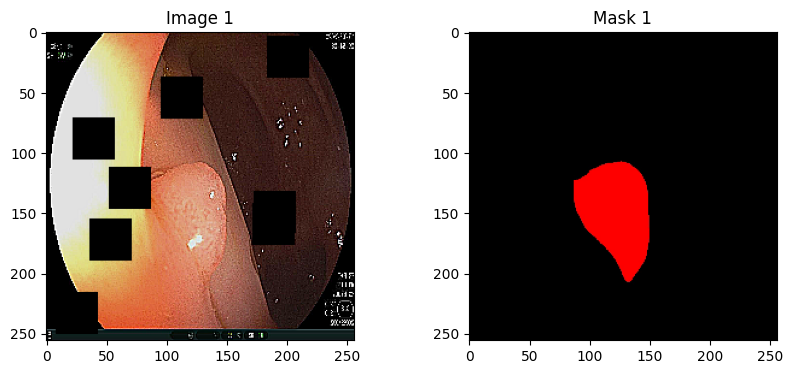

In [41]:
total_files = list(zip(image_files, mask_files))
random.shuffle(total_files)

for image_file, mask_file in total_files:
    image, mask = load_img_mask(image_file, mask_file)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    image, mask = train_img_mask_transform(train_transform, image, mask)

    visualize([image], [mask])
    break